In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh


# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
# plt.rcParams['figure.figsize'] = (16,9)

import mpld3

In [2]:
# reload(sdh)

In [3]:
# reload(nn)
import relembed_single as nn

In [4]:
# reload(eh)
import experiment_helper as eh

In [5]:
shuffle_seed = 20

In [6]:
reload(dh)
DH = dh.DataHandler('data/semeval_wiki_sdp_include_single_50000', valid_percent=1, shuffle_seed=shuffle_seed) # for semeval

Creating Data objects...
Done creating Data objects
471388 total examples :: 466674 training : 4714 valid (99:1 split)
Vocab size: 27070 Dep size: 50 POS size: 18


In [7]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(include_ends=True, shuffle_seed=shuffle_seed, single=False)
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7199
Num valididation: 800
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [8]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

print(train['targets'][:5]) # small sample

[[237, 196], [351, 24436], [5596, 290], [1140, 630], [748, 2727]]


In [9]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 12


In [10]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM
# normalize them
word_embeddings /= np.sqrt(np.sum(word_embeddings**2, 1, keepdims=True))

22777 / 27070 pretrained


In [11]:
def reset_drnn(model_name='relsingle', bi=True, dep_embed_size=25, pos_embed_size=25, 
               word_embed_size=None, max_grad_norm=3., max_to_keep=0, hidden_size=300,
               supervised=True, interactive=True, num_clusters=50):
    if word_embed_size:    
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':word_embed_size,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'hidden_size':hidden_size,
            'bidirectional':bi,
            'num_clusters':num_clusters,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':None,
            'max_grad_norm':3.,
            'model_name':model_name,
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    else: # use pretrained google vectors
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':300,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'hidden_size':hidden_size,
            'bidirectional':bi,
            'num_clusters':num_clusters,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':word_embeddings,
            'max_grad_norm':3.,
            'model_name':model_name,            
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    try:
        tf.reset_default_graph()
    except:
        pass
    try:
        tf.get_default_session().close()
    except:
        pass
    drnn = nn.RelEmbed(config)
    print(drnn)
    return drnn
# drnn = reset_drnn()

In [12]:
def run_validation_test(num_nearby=20):
    # TODO: Pass x_or_y to validation_phrase
    valid_phrases, valid_targets , _, valid_lens, _ = DH.validation_batch()
#     print("V phrase shape", valid_phrases.shape)
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index].reshape((1,-1))
    padded_qp = np.zeros([DH.max_seq_len, 3]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]
    padded_qp[:len(query_phrase), 2] = [x[2] for x in query_phrase] 
    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, query_target,
                                                      valid_phrases, valid_lens, valid_targets)
    print("="*80)
    print("Top %i/%i closest phrases to '%s' <%s>" 
          % (num_nearby, DH.valid_size(),
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[0,0])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f :'%s' <%s>" 
              % (i, dist, 
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[0])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [13]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

In [15]:
def cluster_labels(targets, labels, DH, brown_clusters, num_clusters):
    """Convert labels to integer based on pair of brown clusters"""
    for i, target in enumerate(targets):
#         print(target)
#         x,y = target
#         x = DH.vocab_at(x)
#         y = DH.vocab_at(y)
        y = DH.vocab_at(target[0])
#         try:
#             cx = brown_clusters[x]
#         except KeyError:
#             cx = '<OOV>'
        try:
            cy = brown_clusters[y]
        except KeyError:
            cy = '<OOV>'
#           labels[i] = cluster2int[cx]*num_clusters + cluster2int[cy]
            labels[i] = cluster2int[cy]
    return labels

In [16]:
brown_clusters = {}
lines = open('data/shuffled.en.tok-c100-p1.out/paths', 'r').readlines()
for line in lines:
    vec = line.split()
    brown_clusters[vec[1]] = vec[0]
del lines

In [17]:
cluster2int = {c:i for i,c in enumerate(set(brown_clusters.values()))} 
# add in an OOV cluster
# TODO: Remove this and append semeval data to wiki data bbefore brown clustering
cluster2int['<OOV>'] = 100
print(cluster2int)
num_clusters=len(cluster2int.keys())
print('%i clusters' % num_clusters)

{'11001010': 0, '100100': 1, '100101': 81, '10100': 3, '0011111111': 4, '0011111110': 5, '10011111': 6, '10011110': 7, '11001100111': 8, '11001100110': 9, '1101110': 10, '1101111000': 11, '11001001': 13, '11001000': 14, '11011110010': 15, '01111011': 16, '01111010': 17, '001010': 18, '0111100': 19, '1111010': 20, '1101111010': 21, '01011': 22, '01010': 23, '001111110': 24, '1100110110': 25, '1100110111': 26, '1011101': 27, '1011100': 28, '1100111110': 29, '0111110': 30, '0111111': 31, '110011110': 32, '110001101': 33, '110001100': 12, '101011': 35, '101010': 36, '110011000': 37, '0011110': 38, '1011110': 39, '1011111': 40, '0100': 41, '110010110': 42, '110010111': 43, '1100000': 34, '11110110': 45, '1001110': 84, '00100': 44, '1000': 47, '0011100': 48, '0011101': 49, '11001110': 50, '11000101': 51, '11000100': 52, '001100': 53, '001101': 54, '11011111101': 55, '11011111100': 56, '11011110110': 57, '01101': 58, '01100': 59, '1001100': 60, '1001101': 61, '11010100': 62, '11010101': 63, '

# Unsupervised

In [27]:
# reload(nn)
# drnn = reset_drnn(model_name='wikicluster_state', bi=False, word_embed_size=None, num_clusters=num_clusters)
# reload(dh)
# DH = dh.DataHandler('data/semeval_wiki_sdp_include_single_10000', valid_percent=10, shuffle_seed=shuffle_seed) # for semeval
reload(nn)
drnn = reset_drnn(model_name='wiki_single_50k', bi=True, word_embed_size=None, num_clusters=num_clusters)
# hyperparameters
num_epochs = 3
batch_size =240
target_neg=True
neg_per = 10
neg_level = 1
num_nearby = 50
nearby_mod = 500
sample_power = .75
DH.scale_vocab_dist(sample_power)
DH.scale_target_dist(sample_power)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

best_valid = 100000
best_model = None

for epoch in range(num_epochs):
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, target_neg=target_neg, 
                                             neg_per=neg_per, neg_level=neg_level)):
#         print(batch[-1])
        t0 = time()
        loss, xent = drnn.partial_unsup_fit(*batch)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
#             left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
#             ml,sl = divmod(left, 60)
#             hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f, %1.5f xent :: %0.3f phrases/sec" 
                  % (h,m,s, step, num_steps, epoch, loss, xent, pps))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            valid_batch = DH.validation_batch()
            valid_loss = drnn.validation_loss(*valid_batch)
            
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
#             if valid_loss <= best_valid:
#                 best_valid = valid_loss
#                 best_model = drnn.checkpoint()
        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()
print("Best model was %s" % best_model)
### CLUSTERED ###
# for epoch in range(num_epochs):
#     DH.shuffle_data()
#     for step , batch in enumerate(DH.batches(batch_size, target_neg=target_neg, 
#                                              neg_per=neg_per, neg_level=neg_level)):
#         # turn batch labels into clusters
#         labels = cluster_labels(batch[1], batch[2], DH, brown_clusters, num_clusters)
# #             c1 = brown_clusters
#         t0 = time()
#         loss, xent = drnn.partial_unsup_fit(batch[0], batch[1], labels, batch[3], batch[4])
#         fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
#         if step % 10 == 0:
#             m,s = divmod(time()-start, 60)
#             h,m = divmod(m, 60)
# #             left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
# #             ml,sl = divmod(left, 60)
# #             hl,ml = divmod(ml, 60)
#             pps = batch_size*(neg_per + 1) / fit_time 
#             print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f, %1.5f xent :: %0.3f phrases/sec" 
#                   % (h,m,s, step, num_steps, epoch, loss, xent, pps))
#         if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
#             t0 = time()
#             run_validation_test(num_nearby) # check out the nearby phrases in the validation set
#             valid_batch = DH.validation_batch()
#             valid_labels = cluster_labels(valid_batch[1], valid_batch[2], DH, brown_clusters, num_clusters)
#             valid_loss = drnn.validation_loss(valid_batch[0], valid_batch[1], valid_labels, valid_batch[3], valid_batch[4])
#             print("Validation loss: %0.4f" % valid_loss)
#             nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average
# #             if valid_loss <= best_valid:
# #                 best_valid = valid_loss
# #                 best_model = drnn.checkpoint()
#         if (time() - save_time) > save_interval:
#             print("Saving model...")
#             drnn.checkpoint()
#             save_time = time()
#         total_step +=1
# drnn.checkpoint()
# print("Best model was %s" % best_model)

(?, 300)
<DPNN: W:300, D:25, P:25 H:300, V:27070>
(0:0:6) step 0/1944, epoch 0 Training Loss = 0.69722, 0.69444 xent :: 1186.603 phrases/sec
Top 50/4714 closest phrases to 'he found by <Y>' <maid>
0: 1.000 :'he found by <Y>' <maid>
1: 0.887 :'he hit by <Y>' <trips>
2: 0.851 :'time around replaced by <Y>' <branch>
3: 0.841 :'census conducted by <Y>' <authorities>
4: 0.841 :'part was annexed by <Y>' <melrose>
5: 0.837 :'islands captured by <Y>' <forces>
6: 0.837 :'bath surrounded by <Y>' <wall>
7: 0.837 :'declaration developed by <Y>' <chairman>
8: 0.837 :'sterling acquired by <Y>' <kodak>
9: 0.836 :'information conveyed in <OOV> by <Y>' <fisher>
10: 0.836 :'sun led by <Y>' <ash>
11: 0.835 :'they evicted by <Y>' <police>
12: 0.834 :'inversion produced by <Y>' <reaction>
13: 0.831 :'assault by <Y>' <soldiers>
14: 0.830 :'site at began replaced by <Y>' <1990s>
15: 0.829 :'daughter raised by <Y>' <father>
16: 0.829 :'decision by <Y>' <nrl>
17: 0.827 :'1970s by was in <Y>' <state>
18: 0.827 

# Supervised

In [ ]:
# drnn.checkpoint()
drnn = reset_drnn(model_name='wikigrusep_50k')
drnn.restore('checkpoints/wikigrusep_50k.ckpt-26743-0')

In [20]:
def confusion_matrix(preds, labels, label_set):
    size = len(label_set)
    matrix = np.zeros([size, size]) # rows are predictions, columns are truths
    # fill in matrix
    for p, l in zip(preds, labels):
        matrix[p,l] += 1
    # compute class specific scores
    class_precision = np.zeros(size)
    class_recall = np.zeros(size)
    for label in range(size):
        tp = matrix[label, label]
        fp = np.sum(matrix[label, :]) - tp
        fn = np.sum(matrix[:, label]) - tp
        class_precision[label] = tp/float(tp + fp) if tp or fp else 0
        class_recall[label] = tp/float(tp + fn) if tp or fn else 0
    micro_f1 = np.array([2*(p*r)/(p+r) if p or r else 0 for (p, r) in zip(class_precision, class_recall)])
    avg_precision = np.mean(class_precision)
    avg_recall = np.mean(class_recall)
    macro_f1 = (2*avg_precision*avg_recall) / (avg_precision + avg_recall) if avg_precision and avg_recall else 0
    stats = {'micro_precision':class_precision*100,
             'micro_recall':class_recall*100, 
             'micro_f1':micro_f1*100,
             'macro_precision':avg_precision*100, 
             'macro_recall':avg_recall*100,
             'macro_f1':macro_f1*100}
    return matrix, stats

In [21]:
zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

In [22]:
# reload(nn)
# drnn = reset_drnn(model_name='wikisingle', bi=True, hidden_size=300, word_embed_size=None)
# drnn.restore('wikiall_50k.ckpt-48099-1531')
# drnn.random_restart
batch_size = 50
num_steps = len(train['labels']) // batch_size
num_epochs = 50
display_mod = 10
valid_mod = 50
best_valid = 10e6
early_stop_model = None
start = time()


for epoch in range(num_epochs):
    random.shuffle(zip_train) # shuffling should only happen once per epoch
    _, _, sdps, targets, labels = zip(*zip_train)
    for step in range(num_steps): # num_steps
        class_batch = DH.classification_batch(batch_size, sdps, targets, labels, 
                                              offset=step, shuffle=False, singles=True)
        loss, xent = drnn.partial_class_fit(*class_batch)
        if step % display_mod == 0:   
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("(%i:%i:%i) s %i/%i, e %i avg class xent loss = %0.4f, total loss = %0.4f" 
                  % (h,m,s, step, num_steps, epoch, xent, loss))
        if step % valid_mod == 0:
            valid_batch = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], singles=True)
            valid_loss, valid_xent = drnn.validation_class_loss(*valid_batch)
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            print("="*80)
            print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f, total loss = %0.4f" 
                  % (h,m,s, step, num_steps, epoch, valid_xent, valid_loss))
            print("="*80)
            if valid_xent < best_valid:
                print("New best validation")
                best_valid = valid_xent
                early_stop_model = drnn.checkpoint()
    x_p, y_p, x_t, y_t, _, lens = DH.classification_batch(len(valid['labels']), valid['sdps'], valid['targets'], valid['labels'], singles=True)
    label_set = set(train['labels'])
    preds = drnn.predict(x_p, y_p, x_t, y_t, lens)
    cm, stats = confusion_matrix(preds, valid['labels'], label_set)
    print("Macro F1: %2.4f" % stats['macro_f1'])
# do a final validation
valid_loss, valid_xent = drnn.validation_class_loss(*valid_batch)
m,s = divmod(time()-start, 60)
h,m = divmod(m, 60)
print("="*80)
print("(%i:%i:%i) s %i/%i, e %i validation avg class xent loss = %0.4f, total loss = %0.4f" 
                  % (h,m,s, step, num_steps, epoch, valid_xent, valid_loss))
print("="*80)


model_file = drnn.checkpoint()
if valid_xent < best_valid:
    best_valid = valid_xent
    early_stop_model = model_file

# now take the best of all
print("best model was %s" % early_stop_model)
# drnn.restore(early_stop_model)

(0:0:0) s 0/143, e 0 avg class xent loss = 3.8876, total loss = 42.1643
(0:0:1) s 0/143, e 0 validation avg class xent loss = 3.3899, total loss = 41.5579
New best validation
Saving model to file: checkpoints/wiki_single_50k.ckpt-5832-1
(0:0:9) s 10/143, e 0 avg class xent loss = 3.8610, total loss = 41.0699
(0:0:12) s 20/143, e 0 avg class xent loss = 3.5820, total loss = 39.7499
(0:0:15) s 30/143, e 0 avg class xent loss = 3.2941, total loss = 38.4465
(0:0:18) s 40/143, e 0 avg class xent loss = 3.7088, total loss = 37.8720
(0:0:20) s 50/143, e 0 avg class xent loss = 3.1793, total loss = 36.3794
(0:0:21) s 50/143, e 0 validation avg class xent loss = 3.0673, total loss = 36.1725
New best validation
Saving model to file: checkpoints/wiki_single_50k.ckpt-5832-51
(0:0:31) s 60/143, e 0 avg class xent loss = 3.1966, total loss = 35.4589
(0:0:34) s 70/143, e 0 avg class xent loss = 3.2684, total loss = 34.6175
(0:0:36) s 80/143, e 0 avg class xent loss = 3.0584, total loss = 33.5180
(0:0

In [ ]:
drnn.restore(early_stop_model)

In [ ]:

# write out predictions for test set
test_batch = DH.classification_batch(len(test['targets']), test['sdps'], test['targets'], 
                                     np.zeros(len(test['targets'])), shuffle=False, singles=True)
preds = drnn.predict(test_batch[0], test_batch[1],
                     test_batch[2], test_batch[3],
                     test_batch[5])
with open('SemEval2010_task8_all_data/test_pred.txt', 'w') as f:
    i = 8001
    for pred in preds:
        f.write("%i\t%s\n" % (i, int2label[pred]))
        i += 1

In [ ]:
%%bash
./SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/semeval2010_task8_scorer-v1.2.pl \
SemEval2010_task8_all_data/test_pred.txt SemEval2010_task8_all_data/test_keys.txt

In [ ]:
embeds = drnn.score_w.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds[:,:], aspect='auto', interpolation='nearest')

embeds = drnn.score_bias.eval().reshape([1,-1])
im = ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# ax0.set_yticks([0,300,600,900])
# ax0.set_xticks([])
# ax0.grid()

/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


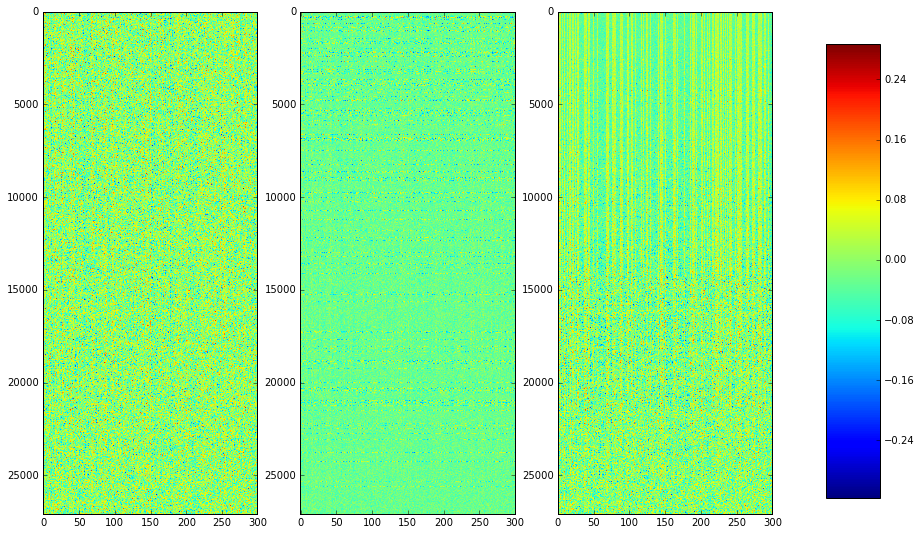

In [23]:
# embeddings
embeds = word_embeddings
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')#, vmin=-2, vmax=2)

embeds = drnn._word_embeddings.eval()
ax1.imshow(embeds, aspect='auto', interpolation='nearest')#, vmin=-2, vmax=2)

embeds = drnn._target_embeddings.eval()
ax2.imshow(embeds, aspect='auto', interpolation='nearest')#, vmin=-2, vmax=2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Top half is input, bottom is r*candidate

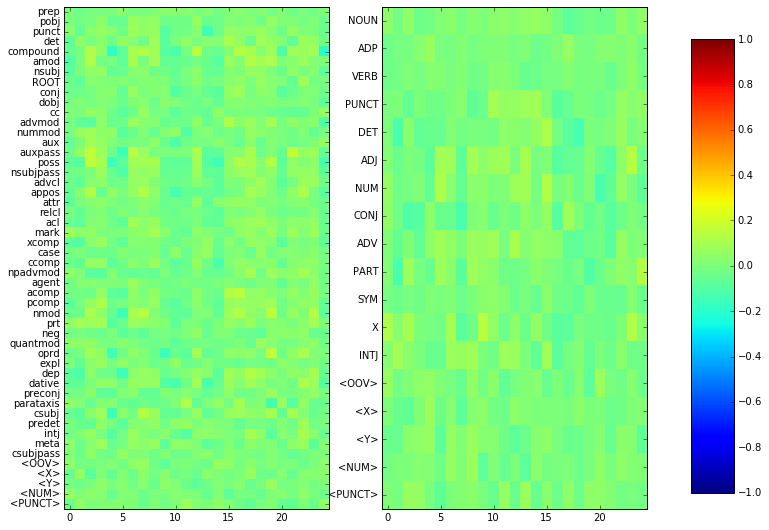

In [24]:
# dep and pos embeddings
embeds = drnn._dependency_embeddings.eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest', vmin=-1, vmax=1)
ax0.set_yticklabels(DH._dep_vocab)
ax0.set_yticks(range(len(DH._dep_vocab)))

embeds = drnn._pos_embeddings.eval()
ax1.imshow(embeds, aspect='auto', interpolation='nearest', vmin=-1, vmax=1)
ax1.set_yticklabels(DH._pos_vocab)
ax1.set_yticks(range(len(DH._pos_vocab)))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [ ]:
print(tf.get_default_graph().get_operations())

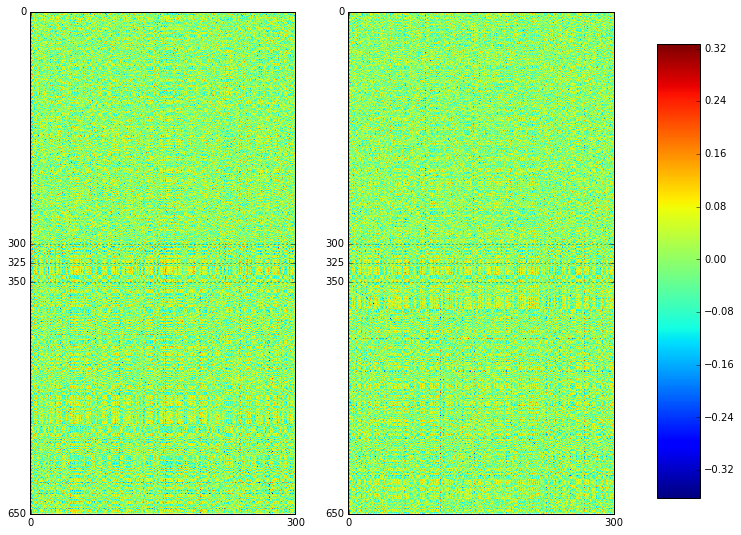

In [25]:
# GRU candidate matrix
with tf.variable_scope('FW', reuse=True):
    embeds = tf.get_variable("GRUCell/Candidate/Linear/Matrix").eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

with tf.variable_scope('BW', reuse=True):
    embeds = tf.get_variable("GRUCell/Candidate/Linear/Matrix").eval()
# embeds = drnn._cand_bias.eval().reshape([1,-1])
ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
ax0.set_yticks([0,300,325,350,650])
ax0.set_xticks([0, 300])
ax0.grid()

ax1.set_yticks([0,300,325,350,650])
ax1.set_xticks([0, 300])
ax1.grid()
### Top half is input, bottom is r*candidate

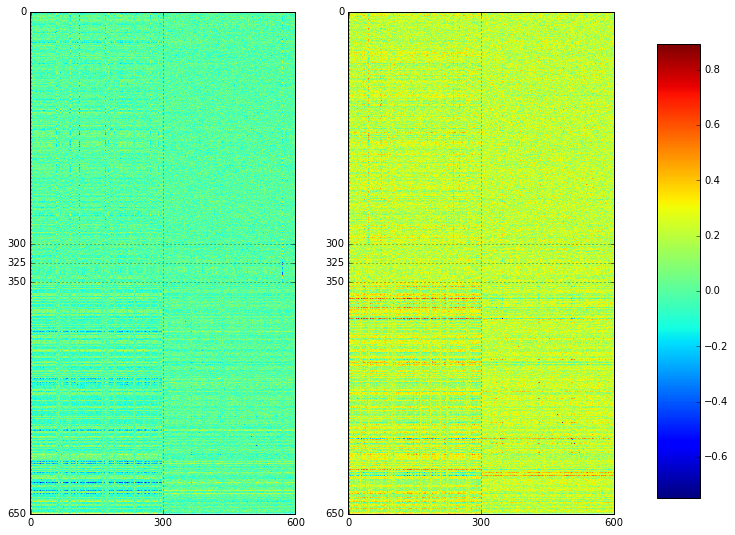

In [26]:
# GRU candidate matrix
with tf.variable_scope('FW', reuse=True):
    embeds = tf.get_variable("GRUCell/Gates/Linear/Matrix").eval()
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,9))
im = ax0.imshow(embeds, aspect='auto', interpolation='nearest')

with tf.variable_scope('BW', reuse=True):
    embeds = tf.get_variable("GRUCell/Gates/Linear/Matrix").eval()
# embeds = drnn._cand_bias.eval().reshape([1,-1])
ax1.imshow(embeds, aspect='auto', interpolation='nearest')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

ax0.set_yticks([0,300,325,350,650])
ax0.set_xticks([0, 300, 600])
ax0.grid()

ax1.set_yticks([0,300,325,350,650])
ax1.set_xticks([0, 300, 600])
ax1.grid()
# Left is r, right is z

In [ ]:
# visualize embedding of large number of phrases
